['pkSeqID', 'stime', 'flgs', 'proto', 'sport', 'dport', 'pkts', 'state', 'ltime', 'seq', 'dur', 'spkts']
[LightGBM] [Info] Number of positive: 741890, number of negative: 741889
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2474
[LightGBM] [Info] Number of data points in the train set: 1483779, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (16.98 MB) transferred to GPU in 0.013290 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000001
[LightGBM] [Info] Start training from score 0.000001
Using GPU acceleration for LightGBM.
Model saved to: models\lgbm_model_trained.pkl
              pr

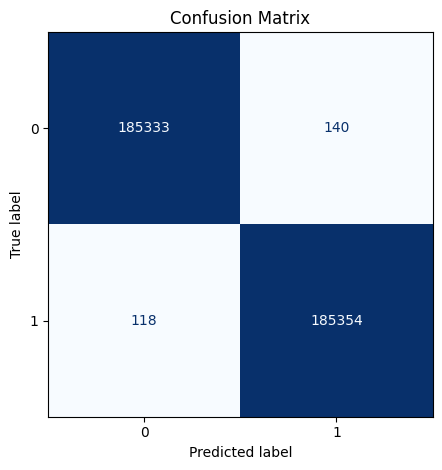

ROC AUC: 1.0000


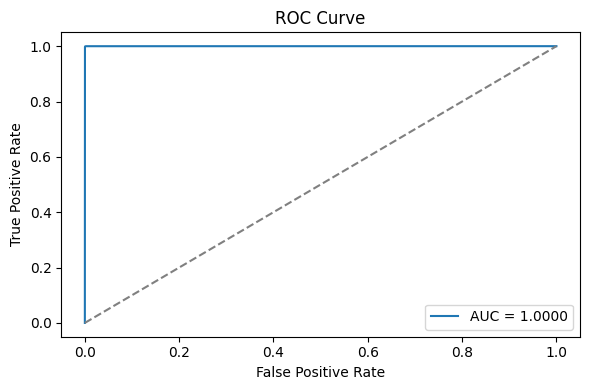

Test accuracy: 0.9993


In [1]:
from pathlib import Path
import pandas as pd
from lightgbm import LGBMClassifier
from lightgbm.basic import LightGBMError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from joblib import dump
import matplotlib.pyplot as plt

best_params = {
    "num_leaves": 44,
    "max_depth": 15,
    "learning_rate": 0.0641720650,
    "n_estimators": 1233,
    "min_child_samples": 21,
    "subsample": 0.6442550582,
    "colsample_bytree": 0.5441757588,
    "reg_alpha": 0.2084502493,
    "reg_lambda": 1.9372339808,
}

label_column = "source"
source_csv_path = Path("balanced_output") / "extracted_features_chunk.csv"

if not source_csv_path.exists():
    raise FileNotFoundError(f"Source CSV not found: {source_csv_path}")

df = pd.read_csv(source_csv_path)

if label_column not in df.columns:
    raise ValueError(f"Column '{label_column}' not found in the dataset.")

non_numeric_cols = [
    col for col in df.columns
    if col != label_column and not pd.api.types.is_numeric_dtype(df[col])
]

for col in non_numeric_cols:
    df[col] = pd.Categorical(df[col]).codes

feature_cols = [
    col for col in df.columns
    if col != label_column and pd.api.types.is_numeric_dtype(df[col])
]
print(feature_cols)

if not feature_cols:
    raise ValueError("No numeric feature columns found for LightGBM training.")

X = df[feature_cols]
y = df[label_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Try GPU acceleration first; gracefully fall back to CPU if unavailable.
lgbm_model = None
try:
    gpu_params = {
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
    }
    lgbm_model = LGBMClassifier(
        **best_params,
        random_state=42,
        n_jobs=-1,
        **gpu_params,
    )
    lgbm_model.fit(X_train, y_train)
    print("Using GPU acceleration for LightGBM.")
except (LightGBMError, TypeError) as exc:
    print(f"GPU training failed ({exc}). Falling back to CPU training.")
    lgbm_model = LGBMClassifier(
        **best_params,
        random_state=42,
        n_jobs=-1,
    )
    lgbm_model.fit(X_train, y_train)

output_v3_folder = Path("models")
output_v3_folder.mkdir(parents=True, exist_ok=True)
model_output_path = output_v3_folder / "lgbm_model_trained.pkl"
dump(lgbm_model, model_output_path)

preds = lgbm_model.predict(X_test)
print(f"Model saved to: {model_output_path}")
print(classification_report(y_test, preds))

ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

probas = lgbm_model.predict_proba(X_test)
if probas.shape[1] == 2:
    roc_auc = roc_auc_score(y_test, probas[:, 1])
    fpr, tpr, _ = roc_curve(y_test, probas[:, 1])
    print(f"ROC AUC: {roc_auc:.4f}")
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("ROC evaluation skipped for multi-class labels.")

test_accuracy = accuracy_score(y_test, preds)
print(f"Test accuracy: {test_accuracy:.4f}")

Dataset shape: (1854724, 12) | Classes: ['0', '1']


,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,roc_auc
0,0.999288,0.999288,0.999288,0.999288,0.999288,0.999993
1,0.999294,0.999294,0.999294,0.999294,0.999294,0.999993
2,0.999369,0.999369,0.999369,0.999369,0.999369,0.999994
3,0.999307,0.999307,0.999307,0.999307,0.999307,0.999994
4,0.999353,0.999353,0.999353,0.999353,0.999353,0.999993


,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,roc_auc
mean,0.999322,0.999322,0.999322,0.999322,0.999322,9.999936e-01
std,0.000037,0.000037,0.000037,0.000037,0.000037,3.729904e-07


,precision,recall,f1-score,support
0,0.999425,0.999219,0.999322,9.273620e+05
1,0.999219,0.999425,0.999322,9.273620e+05
accuracy,0.999322,0.999322,0.999322,9.993223e-01
macro avg,0.999322,0.999322,0.999322,1.854724e+06
weighted avg,0.999322,0.999322,0.999322,1.854724e+06


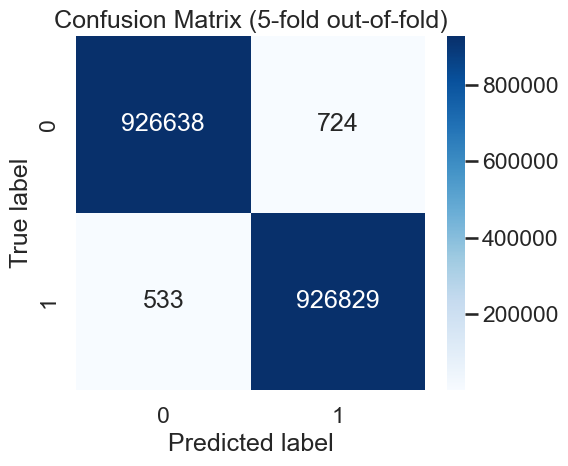

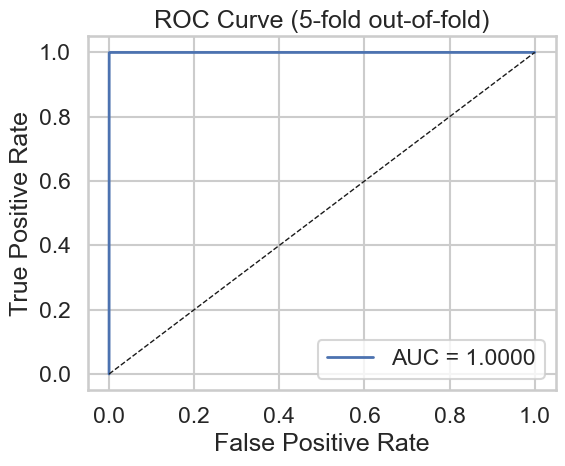

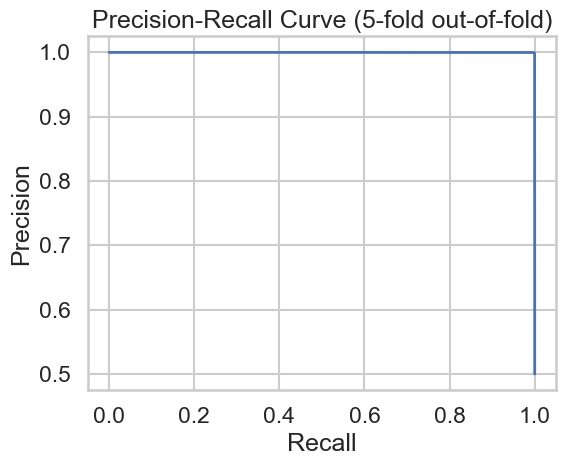

[LightGBM] [Info] Number of positive: 927362, number of negative: 927362
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1854724, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,importance
sport,8160
dur,7216
pkSeqID,7058
stime,6778
dport,6032
ltime,4845
pkts,3981
spkts,3626
flgs,2516
state,1594


C:\Users\z-pc\AppData\Local\Temp\ipykernel_23116\2323258377.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


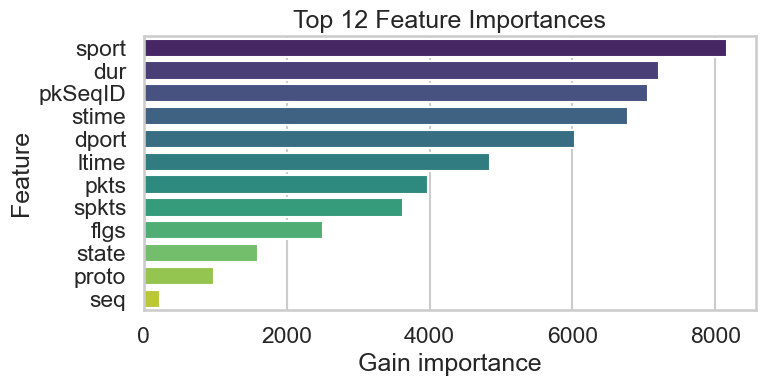

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict

import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
)

sns.set_theme(style="whitegrid", context="talk")

if "X" not in globals() or "y" not in globals():
    raise NameError("Expected variables 'X' and 'y' to be defined in the notebook.")

class_names = [str(cls) for cls in np.sort(np.unique(y))]
num_classes = len(class_names)

if num_classes > 2:
    base_params = {
        "objective": "multiclass",
        "num_class": num_classes,
        "boosting_type": "gbdt",
        "metric": "multi_logloss",
        "device": "cpu",
    }
else:
    base_params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "metric": "binary_logloss",
        "device": "cpu",
    }

best_params = globals().get("best_params", {})

model = lgb.LGBMClassifier(
    n_jobs=-1,
    random_state=42,
    **base_params,
    **best_params,
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}
if num_classes == 2:
    scoring["roc_auc"] = "roc_auc"
else:
    scoring["roc_auc_ovr_weighted"] = "roc_auc_ovr_weighted"

cv_scores = cross_validate(
    model,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False,
)

metric_cols = [col for col in cv_scores if col.startswith("test_")]
fold_metrics = pd.DataFrame(cv_scores)[metric_cols].rename(columns=lambda c: c.replace("test_", ""))
summary_metrics = fold_metrics.agg(["mean", "std"])

print(f"Dataset shape: {X.shape} | Classes: {class_names}")
display(fold_metrics)
display(summary_metrics)

y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
report_df = pd.DataFrame(
    classification_report(y, y_pred, target_names=class_names, output_dict=True)
).T
display(report_df)

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (5-fold out-of-fold)")
plt.tight_layout()
plt.show()

if num_classes == 2:
    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc_value = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_value:.4f}", linewidth=2)
    plt.plot([0, 1], [0, 1], "k--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (5-fold out-of-fold)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    precision, recall, _ = precision_recall_curve(y, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (5-fold out-of-fold)")
    plt.tight_layout()
    plt.show()

model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importance_df = feature_importances.to_frame(name="importance")
display(importance_df)

top_k = min(20, len(feature_importances))
plt.figure(figsize=(8, max(4, top_k * 0.35)))
sns.barplot(
    x=feature_importances.iloc[:top_k],
    y=feature_importances.index[:top_k],
    palette="viridis",
)
plt.xlabel("Gain importance")
plt.ylabel("Feature")
plt.title(f"Top {top_k} Feature Importances")
plt.tight_layout()
plt.show()